### Refactor the feature selector and combine with Boruta
---

In [1]:
import sys, warnings
sys.path.insert(1, '..')

warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
from data.titanic.enums import features, target, cat_idx, cat_features, num_features, categorical_encoder
from sklearn.metrics import accuracy_score
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

In [2]:
# load features
train = pd.read_csv('../data/titanic/train.csv', index_col=0)
valid = pd.read_csv('../data/titanic/valid.csv', index_col=0)
train = pd.concat([train, valid])
train = categorical_encoder(train, cat_features)

# build fake features
for i in range(5):
    train[f'rand_int_{i}'] = np.random.randint(100,size=len(train))
    train[f'rand_uniform_{i}'] = np.random.uniform(0,1,size=len(train))
    train[f'rand_normal_{i}'] = np.random.normal(0,1,size=len(train))
    features.extend([f'rand_int_{i}', f'rand_uniform_{i}', f'rand_normal_{i}'])

In [3]:
# fit a model
clf = lgb.LGBMClassifier(boosting_type='gbdt', metric='logloss', max_depth=3, 
                         n_estimators=100, feature_fraction=0.7, drop_rate=0.15,
                         learning_rate=0.01, random_state=222, num_leaves=41,
                         categorical_feature=cat_idx, silent=True)
%time clf.fit(train[features], train[target])
train['pred'] = clf.predict(train[features])
accuracy_score(train[target], train.pred)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
CPU times: user 446 ms, sys: 675 µs, total: 447 ms
Wall time: 37.2 ms


0.835016835016835

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

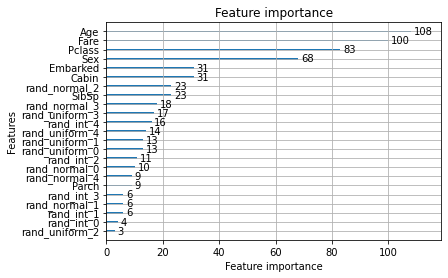

In [4]:
# feature importance
lgb.plot_importance(clf)

### Feature Selector
---

In [3]:
import rdsutils.feature_selection as fs

In [4]:
from rdsutils.feature_selection import FeatureSelector

In [5]:
debug_df = pd.DataFrame({'index': [1,2,3],
                         'age': [10, 20, np.nan],
                         'gender': ['M', 'F', np.nan],
                         'human': [True, True, True], 
                         'just_nan': [np.nan, np.nan, np.nan],
                         'Survived': [1, 0, 1]})

In [6]:
df = train
fsel = FeatureSelector(df, label_cols='Survived', feature_cols=features)
# df = debug_df
# fsel = FeatureSelector(df, label_cols='Survived', feature_cols=debug_df.columns)

In [9]:
fsel.get_missing(0.1)

1 features with greater than                 0.1 missing values


,feature,missing_frac
1,Age,0.198653


In [10]:
fsel.get_single_unique()

0 features with a single unique value.


,feature,nr_unique


In [11]:
fsel.get_lgb_importance('classification', eval_metric='auc', cat_features=cat_features, verbose=-1)

stratifying by labels
fitting models! iteration 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.451239
fitting models! iteration 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.36744
fitting models! iteration 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.395573
fitting models! iteration 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.522366
fitting models! iteration 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.483161


,feature,importance
0,Age,8.597409
1,Fare,7.437010
2,Ticket,6.373683
3,rand_normal_1,5.891515
4,rand_normal_0,5.249494
5,rand_uniform_4,5.162030
6,rand_uniform_0,4.929567
7,rand_int_1,4.825162
8,rand_normal_3,4.693731
9,rand_normal_4,4.660119


In [12]:
model = fsel.get_default_lgb_estimator('classification')
model

LGBMClassifier(n_estimators=1000)

In [13]:
fsel.get_low_feature_importance(5)

,feature,importance
6,rand_uniform_0,4.929567
7,rand_int_1,4.825162
8,rand_normal_3,4.693731
9,rand_normal_4,4.660119
10,rand_int_3,4.562600
11,rand_int_0,4.126847
12,rand_int_2,3.837753
13,rand_normal_2,3.776620
14,rand_uniform_1,3.705396
15,rand_uniform_3,3.686918


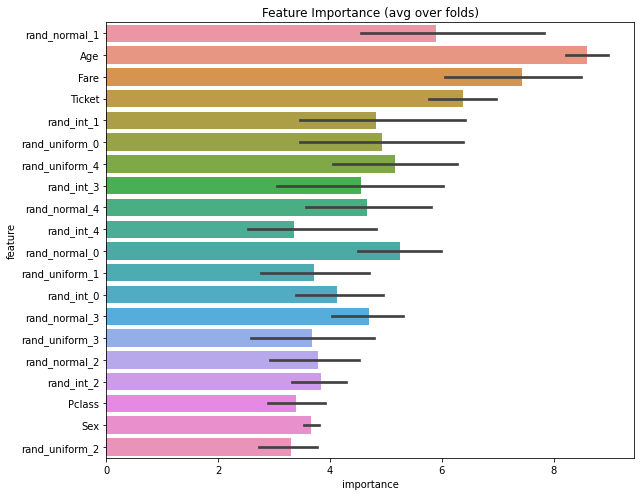

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

In [14]:
fsel.plot_feature_importance()

In [15]:
model = fsel.get_default_lgb_estimator('classification')
bimp = fsel.get_boruta_importance(model, features=features, verbose=1)
fsel.record_boruta_importance.head()

,feature,score,mean_importance
1,Age,7.0,14.618209
4,Fare,3.0,14.449479
6,Ticket,3.0,13.206438
22,rand_uniform_4,-1.0,12.506872
23,rand_normal_4,-2.0,11.614563


In [16]:
fsel.get_woe(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0) 
fsel.get_iv(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0)
fsel.record_iv.head()

producing WOE for all columns with numerical dtype
processed  24  num attributes

WOE fitted
IV produced


,attr,iv
4,Fare,0.5860
7,Cabin,0.3362
1,Age,0.0928
6,Ticket,0.0604
20,rand_normal_3,0.0399


In [40]:
fsel.get_collinear(-0.6, 0.6)

correlation lowerbound: -0.6
correlation upperbound: 0.6
1 features have correlationbeyond bounds provided


(          Pclass     Cabin
 Pclass  1.000000 -0.602223
 Cabin  -0.602223  1.000000,
 [('Pclass', 'Cabin', -0.6022225426630512)])

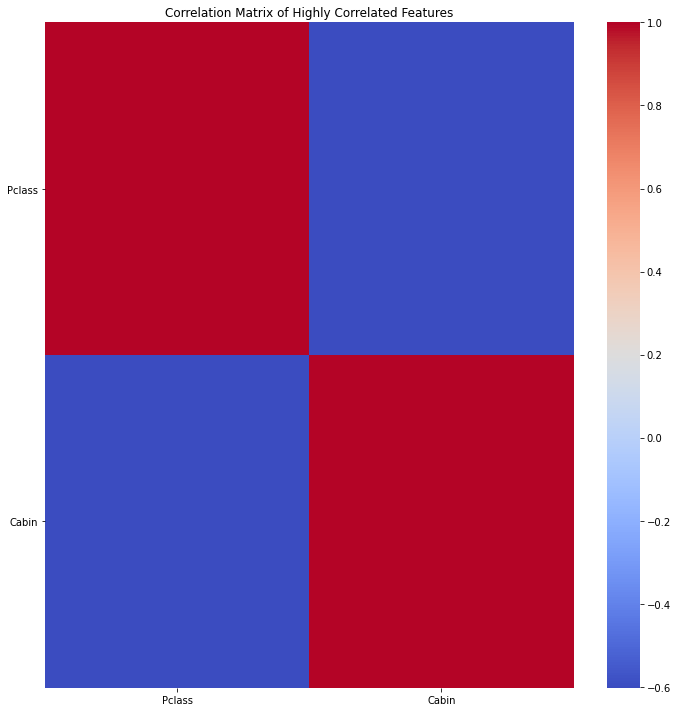

(<Figure size 720x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlation Matrix of Highly Correlated Features'}>)

In [18]:
fsel.plot_collinear()

In [41]:
fsel.save('artifact/fsel.pkl')

In [42]:
import pickle as pkl

obj = pkl.load(open('artifact/fsel.pkl', 'rb'))

In [43]:
obj['record_boruta_importance'].head()

,feature,score,mean_importance
1,Age,7.0,14.618209
4,Fare,3.0,14.449479
6,Ticket,3.0,13.206438
22,rand_uniform_4,-1.0,12.506872
23,rand_normal_4,-2.0,11.614563


In [20]:
fsel2 = FeatureSelector(df, label_cols='Survived', feature_cols=features)
fsel2.load_state_dict('artifact/fsel.pkl')

state dictionary loaded!


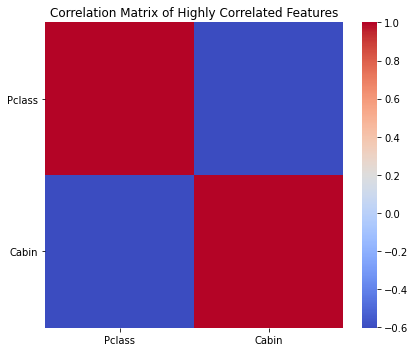

(<Figure size 432x360 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlation Matrix of Highly Correlated Features'}>)

In [25]:
fsel2.plot_collinear(figsize=(6,5), cmap='coolwarm')

In [27]:
fsel2.save_state_dict('artifact/fsel.pkl')

state dictionary saved!


### Try on big dataset
---

In [7]:
%load_ext autoreload
%autoreload 2

from data.customer.enums import features, cat_features, target_cols, preprocess, encoded_features
df = pd.read_parquet('../data/customer/customer_model_df_large.parquet')
df = preprocess(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
df.head()

,business_account_number,borrower_id,sample_date,target,transaction_code,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,...,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred,score
0,410000087395,5750052,2019-03-27 09:59:22,False,ACHDW,50.00,NaN,NaN,0.0272,NaN,...,0.0,0.0,NaN,0.0211,309,5,-1.0,-1.0,0.094489,300.0
1,410001352464,7313147,2019-09-20 05:50:31,False,ACHDDIN,2000.00,734.0,27.0,0.6170,0.312,...,0.0,0.0,6954.0,0.0293,176,4,-1.0,-1.0,0.024634,300.0
2,410000287298,2176154,2019-01-25 05:49:11,False,ACHINDD,100.00,NaN,NaN,0.0108,NaN,...,0.0,0.0,NaN,0.0293,71,6,-1.0,-1.0,0.057510,300.0
3,410000361702,851298,2019-11-25 10:32:35,False,DWCRDBILLPAY,2980.64,780.0,49.0,0.0077,NaN,...,0.0,0.0,6458.0,0.0356,331,0,-1.0,-1.0,0.024610,300.0
4,410000751441,7052381,2019-11-15 06:20:19,False,ACHINDD,300.00,737.0,75.0,0.4790,0.282,...,0.0,0.0,649.0,0.0191,273,6,-1.0,-1.0,0.002071,300.0


In [9]:
class_weight = df.target.value_counts()  
class_weight = class_weight.loc[False] / class_weight.loc[True]
class_weight = {True: class_weight, False: 1}

seed = 15556
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "num_iterations": 1400,
    "max_depth" : 4,
    "num_leaves" : 15,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.8,
    "subsample": 0.94,
    "lambda_l1": 16,
    "lambda_l2": 10,
    "min_data_in_leaf": 116,
    "tree_learner": "feature",
    "verbosity" : -1,
}

fsel = FeatureSelector(df, label_cols=target_cols, feature_cols=features, 
                       id_col=['business_account_number'])

In [10]:
%time fsel.get_collinear(-0.6, 0.6)

correlation lowerbound: -0.6
correlation upperbound: 0.6
4 features have correlationbeyond bounds provided
CPU times: user 5.31 s, sys: 164 ms, total: 5.47 s
Wall time: 5.45 s


(                         vantage_score   bcc7120  sum_deposits_10d   iqt9415  \
 vantage_score                 1.000000 -0.744925          0.092176 -0.207798   
 bcc7120                      -0.744925  1.000000         -0.069596  0.126200   
 sum_deposits_10d              0.092176 -0.069596          1.000000 -0.016189   
 iqt9415                      -0.207798  0.126200         -0.016189  1.000000   
 max_deposits_30d              0.134418 -0.096548          0.702401 -0.027217   
 iqt9413                      -0.129444  0.076197         -0.010109  0.636988   
 all7120_default_encoded      -0.439918       NaN         -0.019105  0.043843   
 bcc7120_default_encoded      -0.518202       NaN         -0.030028  0.051343   
 
                          max_deposits_30d   iqt9413  all7120_default_encoded  \
 vantage_score                    0.134418 -0.129444                -0.439918   
 bcc7120                         -0.096548  0.076197                      NaN   
 sum_deposits_10d         

In [13]:
fsel.get_woe(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0)

producing WOE for all columns with numerical dtype
processed  42  num attributes

WOE fitted


In [14]:
fsel.get_iv(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0)
fsel.record_iv

IV produced


,attr,iv
1,vantage_score,1.7488
36,credit_card_loan_amount,1.4591
17,total_tradelines_open,1.4584
2,bcc7120,1.0514
37,fraud_score_1,0.9461
9,phone_risk_score,0.8913
38,age_money_account,0.8401
3,email_risk_score,0.7414
4,fraud_score_2,0.6840
8,giact_time_since_last_link,0.6359


In [25]:
fsel.get_lgb_importance('classification', class_weight=class_weight,
                        cat_features=cat_features, group_col_name=['business_account_number'],
                        **params)
fsel.get_low_feature_importance()

GroupKFold by group_col_name
fitting models! iteration 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[733]	valid_0's auc: 0.956351
fitting models! iteration 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[946]	valid_0's auc: 0.961528
fitting models! iteration 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[771]	valid_0's auc: 0.960975
fitting models! iteration 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's auc: 0.962703
fitting models! iteration 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[592]	valid_0's auc: 0.960606


,feature,importance


In [26]:
fsel.get_missing(0.1)

11 features with greater than                 0.1 missing values


,feature,missing_frac
2,vantage_score,0.170137
3,bcc7120,0.270244
5,fraud_score_2,0.227301
12,all8220,0.182307
15,all7120,0.223189
18,total_tradelines_open,0.150891
19,education_loan_amount,0.150891
21,iqt9415,0.163908
23,iln5520,0.499498
34,iqt9413,0.163908


In [15]:
model = fsel.get_default_lgb_estimator('classification')
%time fsel.get_boruta_importance(model, features=encoded_features, verbose=1)

CPU times: user 2h 28min 24s, sys: 9.7 s, total: 2h 28min 33s
Wall time: 10min 4s


,feature,score,mean_importance
37,fraud_score_1,20.0,7.145468
13,dollar_val_dd,20.0,6.755775
3,email_risk_score,20.0,5.138906
1,vantage_score,20.0,5.065362
4,fraud_score_2,20.0,4.957441
19,address_risk_score,20.0,4.580802
0,first_deposit_amount,20.0,4.462219
7,mean_account_balance_30d,20.0,4.221353
11,all8220,20.0,4.066433
9,phone_risk_score,20.0,3.886708


In [16]:
fsel.record_boruta_importance

,feature,score,mean_importance
37,fraud_score_1,20.0,7.145468
13,dollar_val_dd,20.0,6.755775
3,email_risk_score,20.0,5.138906
1,vantage_score,20.0,5.065362
4,fraud_score_2,20.0,4.957441
19,address_risk_score,20.0,4.580802
0,first_deposit_amount,20.0,4.462219
7,mean_account_balance_30d,20.0,4.221353
11,all8220,20.0,4.066433
9,phone_risk_score,20.0,3.886708


In [17]:
hex(id(df)), hex(id(df[['business_account_number', 'borrower_id']]))

('0x7f4c66f21c50', '0x7f4c64005e90')

In [18]:
# get removal order by flipping boruta_importance
fimp = fsel.record_boruta_importance
removal_order = fimp.sort_values('mean_importance', 
                                 ascending=True).feature.to_list()


In [22]:
fsel.record_collinear_pairs

[('vantage_score', 'bcc7120', -0.7449249267449053),
 ('sum_deposits_10d', 'max_deposits_30d', 0.7024005443566413),
 ('iqt9415', 'iqt9413', 0.636987833865434),
 ('all7120_default_encoded', 'bcc7120_default_encoded', 0.7280106454029602)]

In [20]:
fsel.get_collinear_features_to_drop(removal_order)

['all7120_default_encoded', 'iqt9413', 'sum_deposits_10d', 'bcc7120']